In [1]:
## Cell required to run other cells in the file
%pylab inline
import pandas as pd
import glob, re, os
import scipy
import pickle
import sz
from IPython.core.debugger import Tracer

import traceback
import warnings
import sys
# warnings.filterwarnings('error')
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    traceback.print_stack()
    log = file if hasattr(file,'write') else sys.stderr
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
## uncomment the following line to have detailed warning info
# warnings.showwarning = warn_with_traceback

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'Bitstream Vera Sans','sans-serif':['Helvetica']})

### Load the created data
rawvar = pd.read_hdf('pythondata/hiwcdata.h5',key='rawvar')
rawpsd = pd.read_hdf('pythondata/hiwcdata.h5',key='rawpsd')
bin_div = pd.read_hdf('pythondata/hiwcdata.h5',key='bin_div').as_matrix().ravel()

# file not yet opened
with open('pythondata/mmd.p', 'rb') as f:
    # file opened
    MMD = pickle.load(f)
    # file opened
# file closed

with open('pythondata/fitted.p', 'rb') as f:
    # file opened
    FITS = pickle.load(f)
    # file opened
# file closed

numofflts = 23
rootpath = '/data/mcfarq/a/szhu28/research/HIWC/data/fulldataDarwin'

## Creating iwc
iwc = rawvar['XKBZR5s']
temp = rawvar['air_temperature']
## Creating NML
targetarr = []
for x in FITS:
    ## None means less than 10 valid bins are present,
    ## 'Error' means the fitting fails for the PSD
    if (x is None) or (x == 'Error'):
        targetarr.append([np.nan]*3)
    else:
        targetarr.append(x.x)
#         print('Warning! Not aligned!')
#         print(x)
NML = np.array(targetarr)

## Create dataset dataf combining rawvar and nml, which is still same len as rawvar
temp = rawvar['air_temperature']
nml = np.empty((len(iwc),3))+np.nan
nml[rawpsd['indpsdbackward'],:] = NML
n0 = nml[:,0]
mu = nml[:,1]
ld = nml[:,2]
mmd = np.empty((len(iwc),))+np.nan
mmd[rawpsd['indpsdbackward']] = MMD
indpsdforward = rawvar['indpsdforward']

dataf = rawvar
dataf['temp'] = temp
dataf['indpsdforward'] = indpsdforward
dataf['n0'] = n0
dataf['mu'] = mu
dataf['ld'] = ld
dataf['mmd'] = mmd
dataf['iwc'] = iwc
## Example usage of sub-setting
# ind = (iwc>0.5)
# ind = (ind) & (~isnan(rawvar['indpsdforward']))
# tmpiwc = iwc[np.array(ind)]
# ind = rawvar['indpsdforward'][ind].as_matrix().astype(int)
# mmd = MMD[ind]
# ind2 = ~isnan(mmd)
# tmpiwc = tmpiwc[ind2]
# mmd = mmd[ind2]

## Easy function to sub-setting data based on iwc, temperature, mmd based on dataf
def subsetdata(tempr=[-inf,inf], iwcr=[-inf,inf], mmdr=[-inf,inf],msd=False,flightnum=None):

    tmpind = (dataf['temp']>tempr[0]) & (dataf['temp']<tempr[1])
    tmpind = tmpind & (dataf['iwc']>iwcr[0]) & (dataf['iwc']<iwcr[1])
    # tmpind = (dataf['temp']>-37.5) & (dataf['temp']<-32.5)
    # tmpind = tmpind & (dataf['iwc']<5) & (dataf['iwc']>2.5)
    tmpind = tmpind & (dataf['mmd']>mmdr[0]) & (dataf['mmd']<mmdr[1])
    if flightnum is not None:
        tmpind = tmpind & (dataf['flightnum']==flightnum)
    tmpdataf = dataf[tmpind]
    
    tmpindrawvar = tmpdataf['indpsdforward']
    tmpindrawvar = tmpindrawvar[~isnan(tmpindrawvar)].astype(int)
    
    tmpindrawvar = rawpsd['indpsdbackward'][tmpindrawvar]

    indlvl1 = ~isnan(tmpdataf['indpsdforward'])
    a = tmpdataf['indpsdforward'][indlvl1]
    nonpsd = tmpdataf[indlvl1]
    if msd==False:
        psd = rawpsd['psddmax'].iloc[ a.astype(int),: ]
    else:
        psd = rawpsd['msddmax'].iloc[ a.astype(int),: ]
    ## Use rawvar.iloc[tmpindrawvar] for data access
    return nonpsd,psd, tmpindrawvar

Populating the interactive namespace from numpy and matplotlib


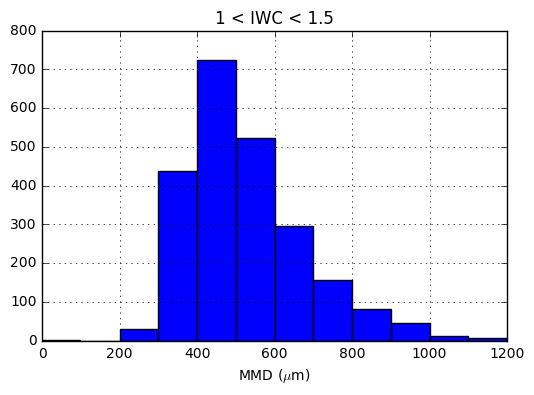

/data/keeling/a/szhu28/usr/anaconda2/envs/py3k/lib/python3.5/site-packages/matplotlib/axes/_axes.py:5991: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


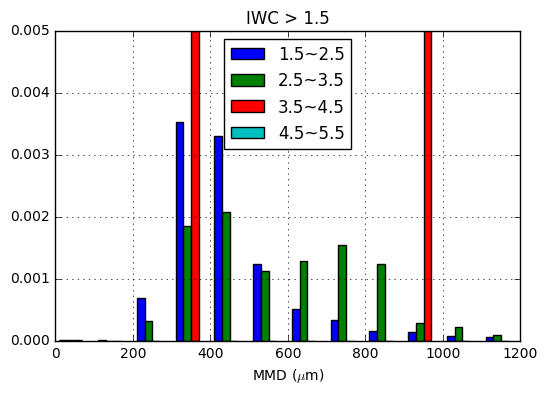

In [2]:
ind = (iwc>1.) & (iwc<1.5)
ind = (ind) & (~isnan(rawvar['indpsdforward']))
ind = rawvar['indpsdforward'][ind].as_matrix().astype(int)

nml = NML[ind,:]
mmd = MMD[ind]

plt.hist(mmd[~isnan(mmd)],bins=12,range=(0,1200))
plt.title('1 < IWC < 1.5')
rc('text', usetex=True)
plt.xlabel(r'MMD ($\mu$m)')
rc('text', usetex=False)
plt.grid(b=True)
plt.show()

tmplist = []
# iwc = iwc.as_matrix()
for ind in  [ (2.5>iwc) & (iwc>=1.5) , (3.5>iwc) & (iwc>=2.5) , (4.5>iwc) & (iwc>=3.5) , (5.5>iwc) & (iwc>=4.5) ]:
    ind = (ind) & (~isnan(rawvar['indpsdforward']))
    ind = rawvar['indpsdforward'][ind].as_matrix().astype(int)

    nml = NML[ind,:]
    mmd = MMD[ind]
    tmp = mmd[~isnan(mmd)]
    tmplist.append(tmp)

a = plt.hist(tmplist,stacked=False,bins=12,range=(0,1200),normed=True)
plt.legend([r'1.5~2.5','2.5~3.5','3.5~4.5','4.5~5.5'],loc='best')
plt.title(r'IWC > 1.5')
rc('text', usetex=True)
plt.xlabel(r'MMD ($\mu$m)')
rc('text', usetex=False)
plt.grid(b=True)
plt.show()

(613.97022332506208, 199.1149626324422)

/data/keeling/a/szhu28/usr/anaconda2/envs/py3k/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


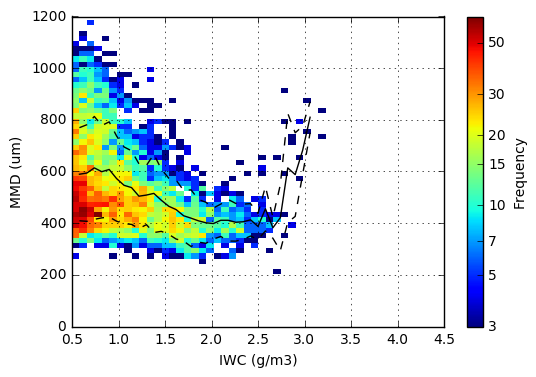

In [5]:
ind = (iwc>0.5)
ind = (ind) & (~isnan(rawvar['indpsdforward']))
tmpiwc = iwc[np.array(ind)]
ind = rawvar['indpsdforward'][ind].as_matrix().astype(int)
mmd = MMD[ind]
ind2 = ~isnan(mmd)
tmpiwc = tmpiwc[ind2]
mmd = mmd[ind2]
# any(isnan(mmd))

from matplotlib.colors import LogNorm
output = plt.hist2d(tmpiwc,mmd,range=[[0.5,4.5],[0,1200]],bins=np.array([10,12])*5,norm=LogNorm(),cmin=3)
cb = plt.colorbar()
cb.set_label('Frequency')
clabellist = [3,5,7,10,15,20,30,50,100]
cb.set_ticks(clabellist, update_ticks=True)
cb.set_ticklabels(clabellist)
plt.grid(b=True)
plt.xlabel('IWC (g/m3)')
plt.ylabel('MMD (um)')

import numpy.ma as ma
iwcmmdct = output[0].transpose()
f = output[2]
f = (f[:-1]+f[1:])/2.
x = output[1][1:]
marray = ma.masked_array(iwcmmdct,isnan(iwcmmdct))
meanval = ma.average(tile(f,[50,1]).transpose(),axis=0,weights=marray)
meanstd = ma.sqrt(ma.average((tile(f,[50,1]).transpose()-meanval)**2,axis=0,weights=marray))
plt.plot(x,meanval,'k-')
plt.plot(x,meanval+meanstd,'k--')
plt.plot(x,meanval-meanstd,'k--')
meanval[2],meanstd[2]

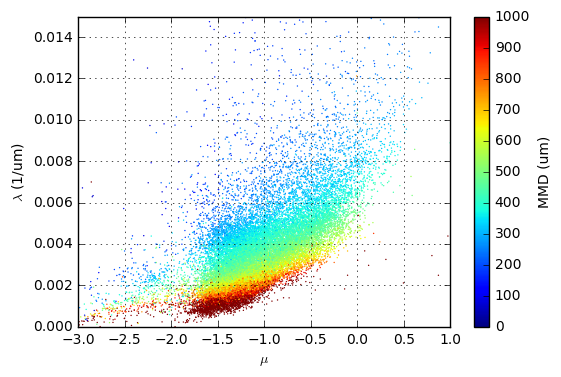

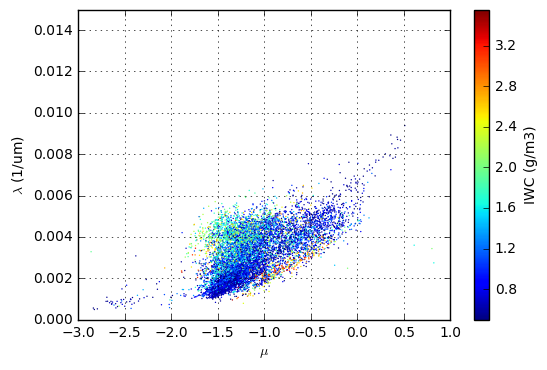

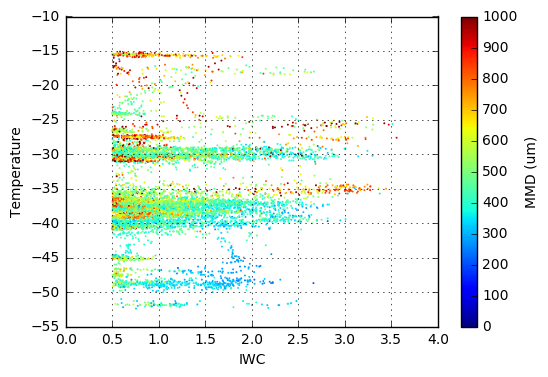

In [4]:
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(dataf.mu, dataf.ld, c=dataf.mmd, s=1, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.show()

tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5)]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.mu, tmpdataf.ld, c=tmpdataf.iwc, s=1, **collection)
cb = plt.colorbar()
cb.set_label('IWC (g/m3)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
# plt.clim(0,1000)
plt.grid(b=True)
plt.show()

tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5)]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('IWC')
plt.ylabel(r'Temperature')
# plt.xlim(-3,1)
# plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.show()

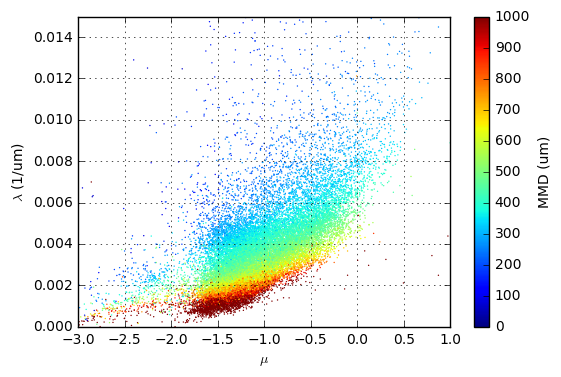

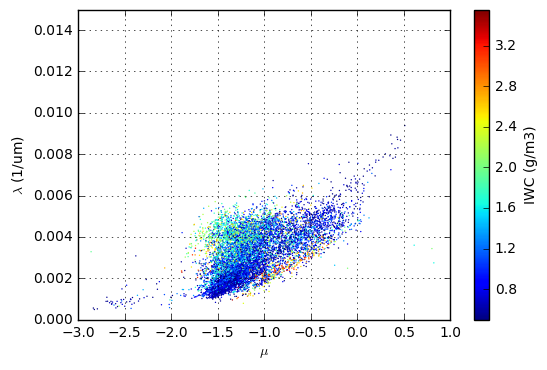

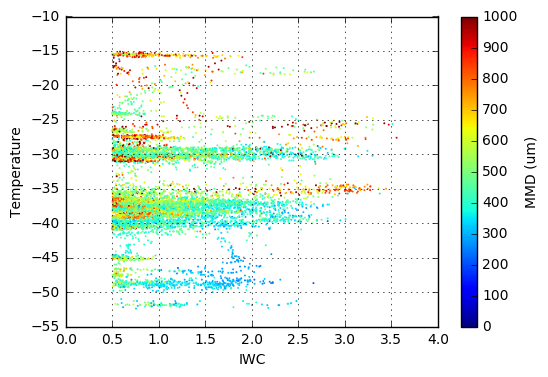

In [4]:
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(dataf.mu, dataf., c=dataf.mmd, s=1, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.show()

scatter(dataf.mu, dataf.ld, c=dataf.mmd, s=1, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.show()


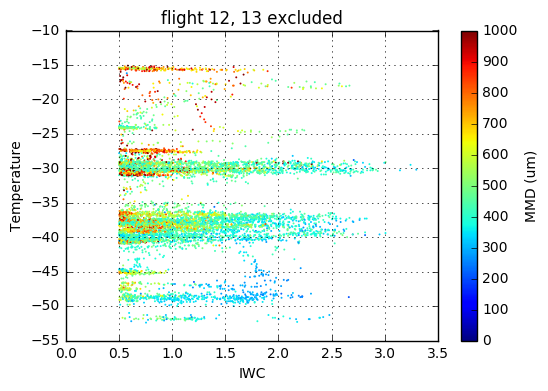

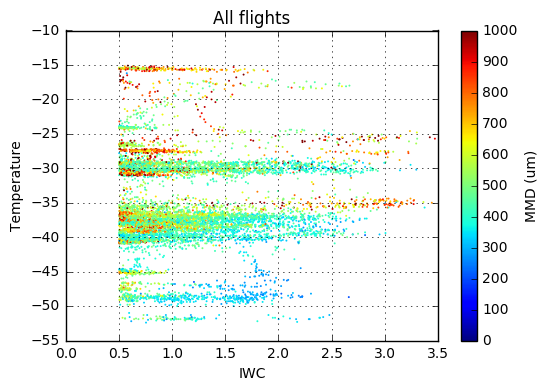

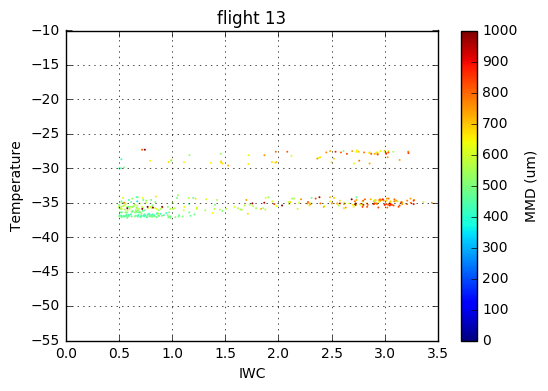

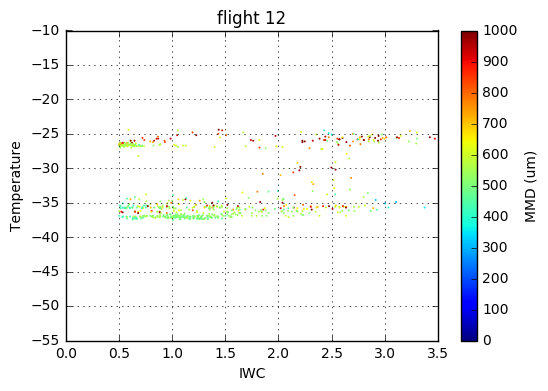

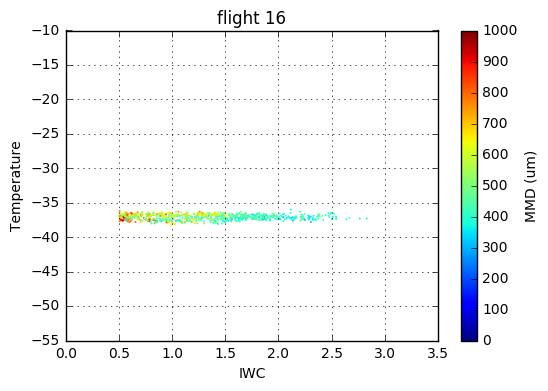

In [3]:
tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5) & ((dataf['flightnum']!=13) & (dataf['flightnum']!=12))]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('IWC')
plt.ylabel(r'Temperature')
plt.xlim(0,3.5)
plt.ylim(-55,-10)
plt.clim(0,1000)
plt.grid(b=True)
plt.title('flight 12, 13 excluded')
plt.show()

tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5)]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('IWC')
plt.ylabel(r'Temperature')
plt.xlim(0,3.5)
plt.ylim(-55,-10)
plt.clim(0,1000)
plt.grid(b=True)
plt.title('All flights')
plt.show()

tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5) & (dataf['flightnum']==13)]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('IWC')
plt.ylabel(r'Temperature')
plt.xlim(0,3.5)
plt.ylim(-55,-10)
plt.clim(0,1000)
plt.grid(b=True)
plt.title('flight 13')
plt.show()

tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5) & (dataf['flightnum']==12)]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('IWC')
plt.ylabel(r'Temperature')
plt.xlim(0,3.5)
plt.ylim(-55,-10)
plt.clim(0,1000)
plt.grid(b=True)
plt.title('flight 12')
plt.show()

tmpdataf = dataf[(dataf['temp']<-15) & (dataf['iwc']>.5) & (dataf['flightnum']==16)]
collection = {'linewidths':0,'antialiaseds':True}
## All PSD's
scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('IWC')
plt.ylabel(r'Temperature')
plt.xlim(0,3.5)
plt.ylim(-55,-10)
plt.clim(0,1000)
plt.grid(b=True)
plt.title('flight 16')
plt.show()

19


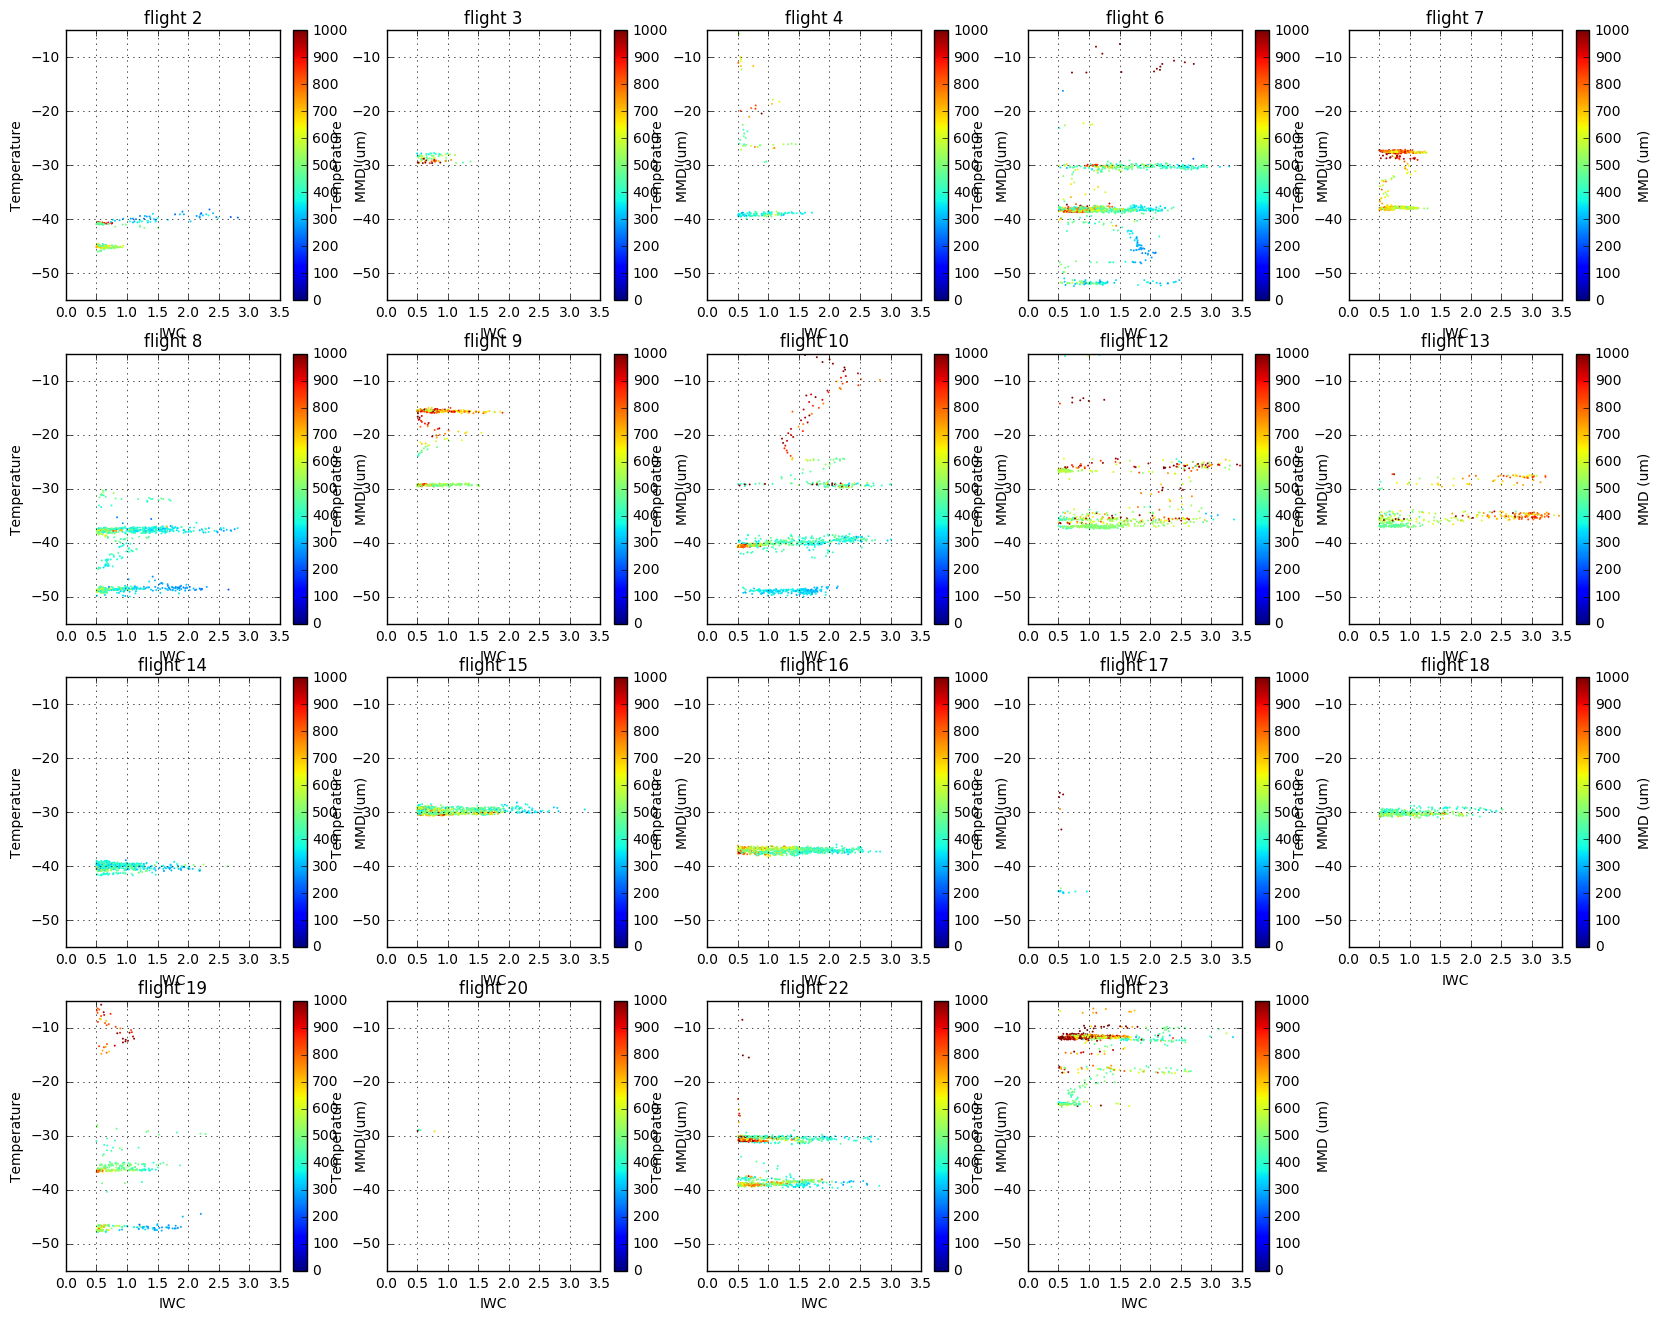

In [34]:
counter = 0
plt.figure(figsize=[20,16])
for szi in range(23):
    tmpdataf = dataf[(dataf['temp']<-5) & (dataf['iwc']>.5) & (dataf['flightnum']==szi+1)]
    if len(tmpdataf)<20:
        continue
    collection = {'linewidths':0,'antialiaseds':True}
    counter+=1
    ## All PSD's
    plt.subplot(4,5,counter)
    scatter(tmpdataf.iwc, tmpdataf.temp, c=tmpdataf.mmd, s=2, **collection)
    cb = plt.colorbar()
    cb.set_label('MMD (um)')
    plt.xlabel('IWC')
    plt.ylabel(r'Temperature')
    plt.xlim(0,3.5)
    plt.ylim(-55,-5)
    plt.clim(0,1000)
    plt.grid(b=True)
    plt.title('flight '+str(szi+1))
print(counter)
plt.show()

## Figure explanation
To explore some cases of large MMD (>800um), two regions in the IWC-temperature space (the figure **above**) are selected. First one is temperature between -37.5 to -32.5 with high iwc (>2.5) (Denoted as **region A**). Second region (Denoted as **region B**) is temperature -40<-35 and iwc between (0.5,1). Only PSD's with MMD between (800,900) are selected. A third region (denoted as **C**) is selected as a comparison for PSD's of MMD (400,500) and IWC (>0.5), temperature between (-40.,-32.5).

In the **following** figure panel, first one shows cumulated mass size function, second one the normalied cumulated mass size function. Red line represents region A, blue region B, black region C. In second figure, blue and red lines shares the same MMD at 0.5 normalized mass size.

Also note that all the PSD's in the region A (high IWC with large MMD) come exclusively from flight 13, while region B composed of PSD's from flight 6,7,16,22 (lower IWC with large MMD, correspondent to generally negative IWC-MMD correlation).

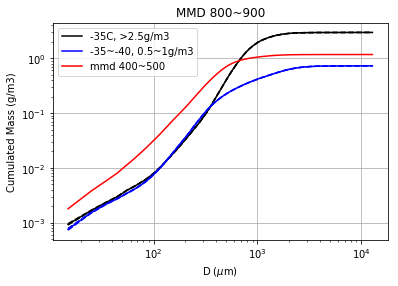

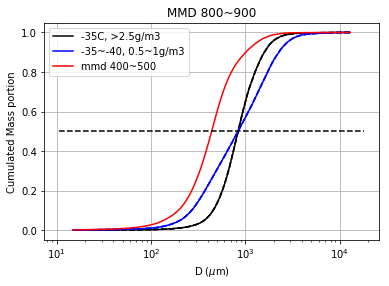

In [3]:
bin_mid = (bin_div[1:] + bin_div[:-1] )/2.

nonpsd1,psd, _ = subsetdata(tempr=[-37.5,-32.5],iwcr=[2.5,5],mmdr=[800,900],msd=True)
psdmean = mean(psd,axis=0)
psdmean = cumsum(psdmean*10.)
rc('text', usetex=False)
plt.loglog(bin_mid,psdmean,'k-',label=r'-35C, >2.5g/m3')
psdstd = std(psd,axis=0)
plt.loglog(bin_mid,psdmean+psdstd,'k--')
plt.loglog(bin_mid,psdmean-psdstd,'k--')
plt.grid(b=True)

nonpsd2,psd, _ = subsetdata(tempr=[-40,-35],iwcr=[.5,1],mmdr=[800,900],msd=True)
psdmean = mean(psd,axis=0)
psdmean = cumsum(psdmean*10.)
plt.loglog(bin_mid,psdmean,'b-',label='-35~-40, 0.5~1g/m3')
psdstd = std(psd,axis=0)
plt.loglog(bin_mid,psdmean+psdstd,'b--')
plt.loglog(bin_mid,psdmean-psdstd,'b--')
plt.grid(b=True)
plt.title('MMD 800~900')

nonpsd,psd,_ = subsetdata(tempr=[-40.,-32.5],iwcr=[.5,inf],mmdr=[400,500],msd=True)
psdmean = mean(psd,axis=0)
psdmean = cumsum(psdmean*10.)
plt.loglog(bin_mid,psdmean,'r-',label='mmd 400~500')
psdstd = std(psd,axis=0)
# plt.loglog(bin_mid,psdmean+psdstd,'r--')
# plt.loglog(bin_mid,psdmean-psdstd,'r--')
plt.grid(b=True)
plt.legend(loc='best')
plt.title('MMD 800~900')
plt.xlabel('D ($\mu$m)')
plt.ylabel('Cumulated Mass (g/m3)')

plt.show()

nonpsd1,psd, _ = subsetdata(tempr=[-37.5,-32.5],iwcr=[2.5,5],mmdr=[800,900],msd=True)
psdmean = mean(psd,axis=0)
psdmean = cumsum(psdmean*10.)
psdmean /= psdmean[-1]
rc('text', usetex=False)
plt.loglog(bin_mid,psdmean,'k-',label=r'-35C, >2.5g/m3')
psdstd = std(psd,axis=0)
plt.loglog(bin_mid,psdmean+psdstd,'k--')
plt.loglog(bin_mid,psdmean-psdstd,'k--')
plt.grid(b=True)

nonpsd2,psd, _ = subsetdata(tempr=[-40,-35],iwcr=[.5,1],mmdr=[800,900],msd=True)
psdmean = mean(psd,axis=0)
psdmean = cumsum(psdmean*10.)
psdmean /= psdmean[-1]
plt.loglog(bin_mid,psdmean,'b-',label='-35~-40, 0.5~1g/m3')
psdstd = std(psd,axis=0)
plt.loglog(bin_mid,psdmean+psdstd,'b--')
plt.loglog(bin_mid,psdmean-psdstd,'b--')
plt.grid(b=True)
plt.title('MMD 800~900')

nonpsd,psd,_ = subsetdata(tempr=[-40.,-32.5],iwcr=[.5,inf],mmdr=[400,500],msd=True)
psdmean = mean(psd,axis=0)
psdmean = cumsum(psdmean*10.)
psdmean /= psdmean[-1]
plt.loglog(bin_mid,psdmean,'r-',label='mmd 400~500')
psdstd = std(psd,axis=0)
# plt.loglog(bin_mid,psdmean+psdstd,'r--')
# plt.loglog(bin_mid,psdmean-psdstd,'r--')
plt.grid(b=True)
plt.legend(loc='best')
plt.title('MMD 800~900')
plt.xlabel('D ($\mu$m)')
plt.ylabel('Cumulated Mass portion')
plt.gca().set_yscale('linear')
plt.plot(plt.xlim(),[.5,.5],'k--')
plt.show()

## Figure explanation
In the folowing panel PSD (first one) and MSD (second one) of the same three regions defined above are plotted. The third figure shows the Region A and Region B in the $\lambda-\mu$ phase space. Red -- region A, blue -- region B. In the fourth figure the dots are plotted over the entire database. While the blue dots remain unchanged against figure 3, the red dots in figure 3 are colored black in figure 4 for better visual contrast against the background.

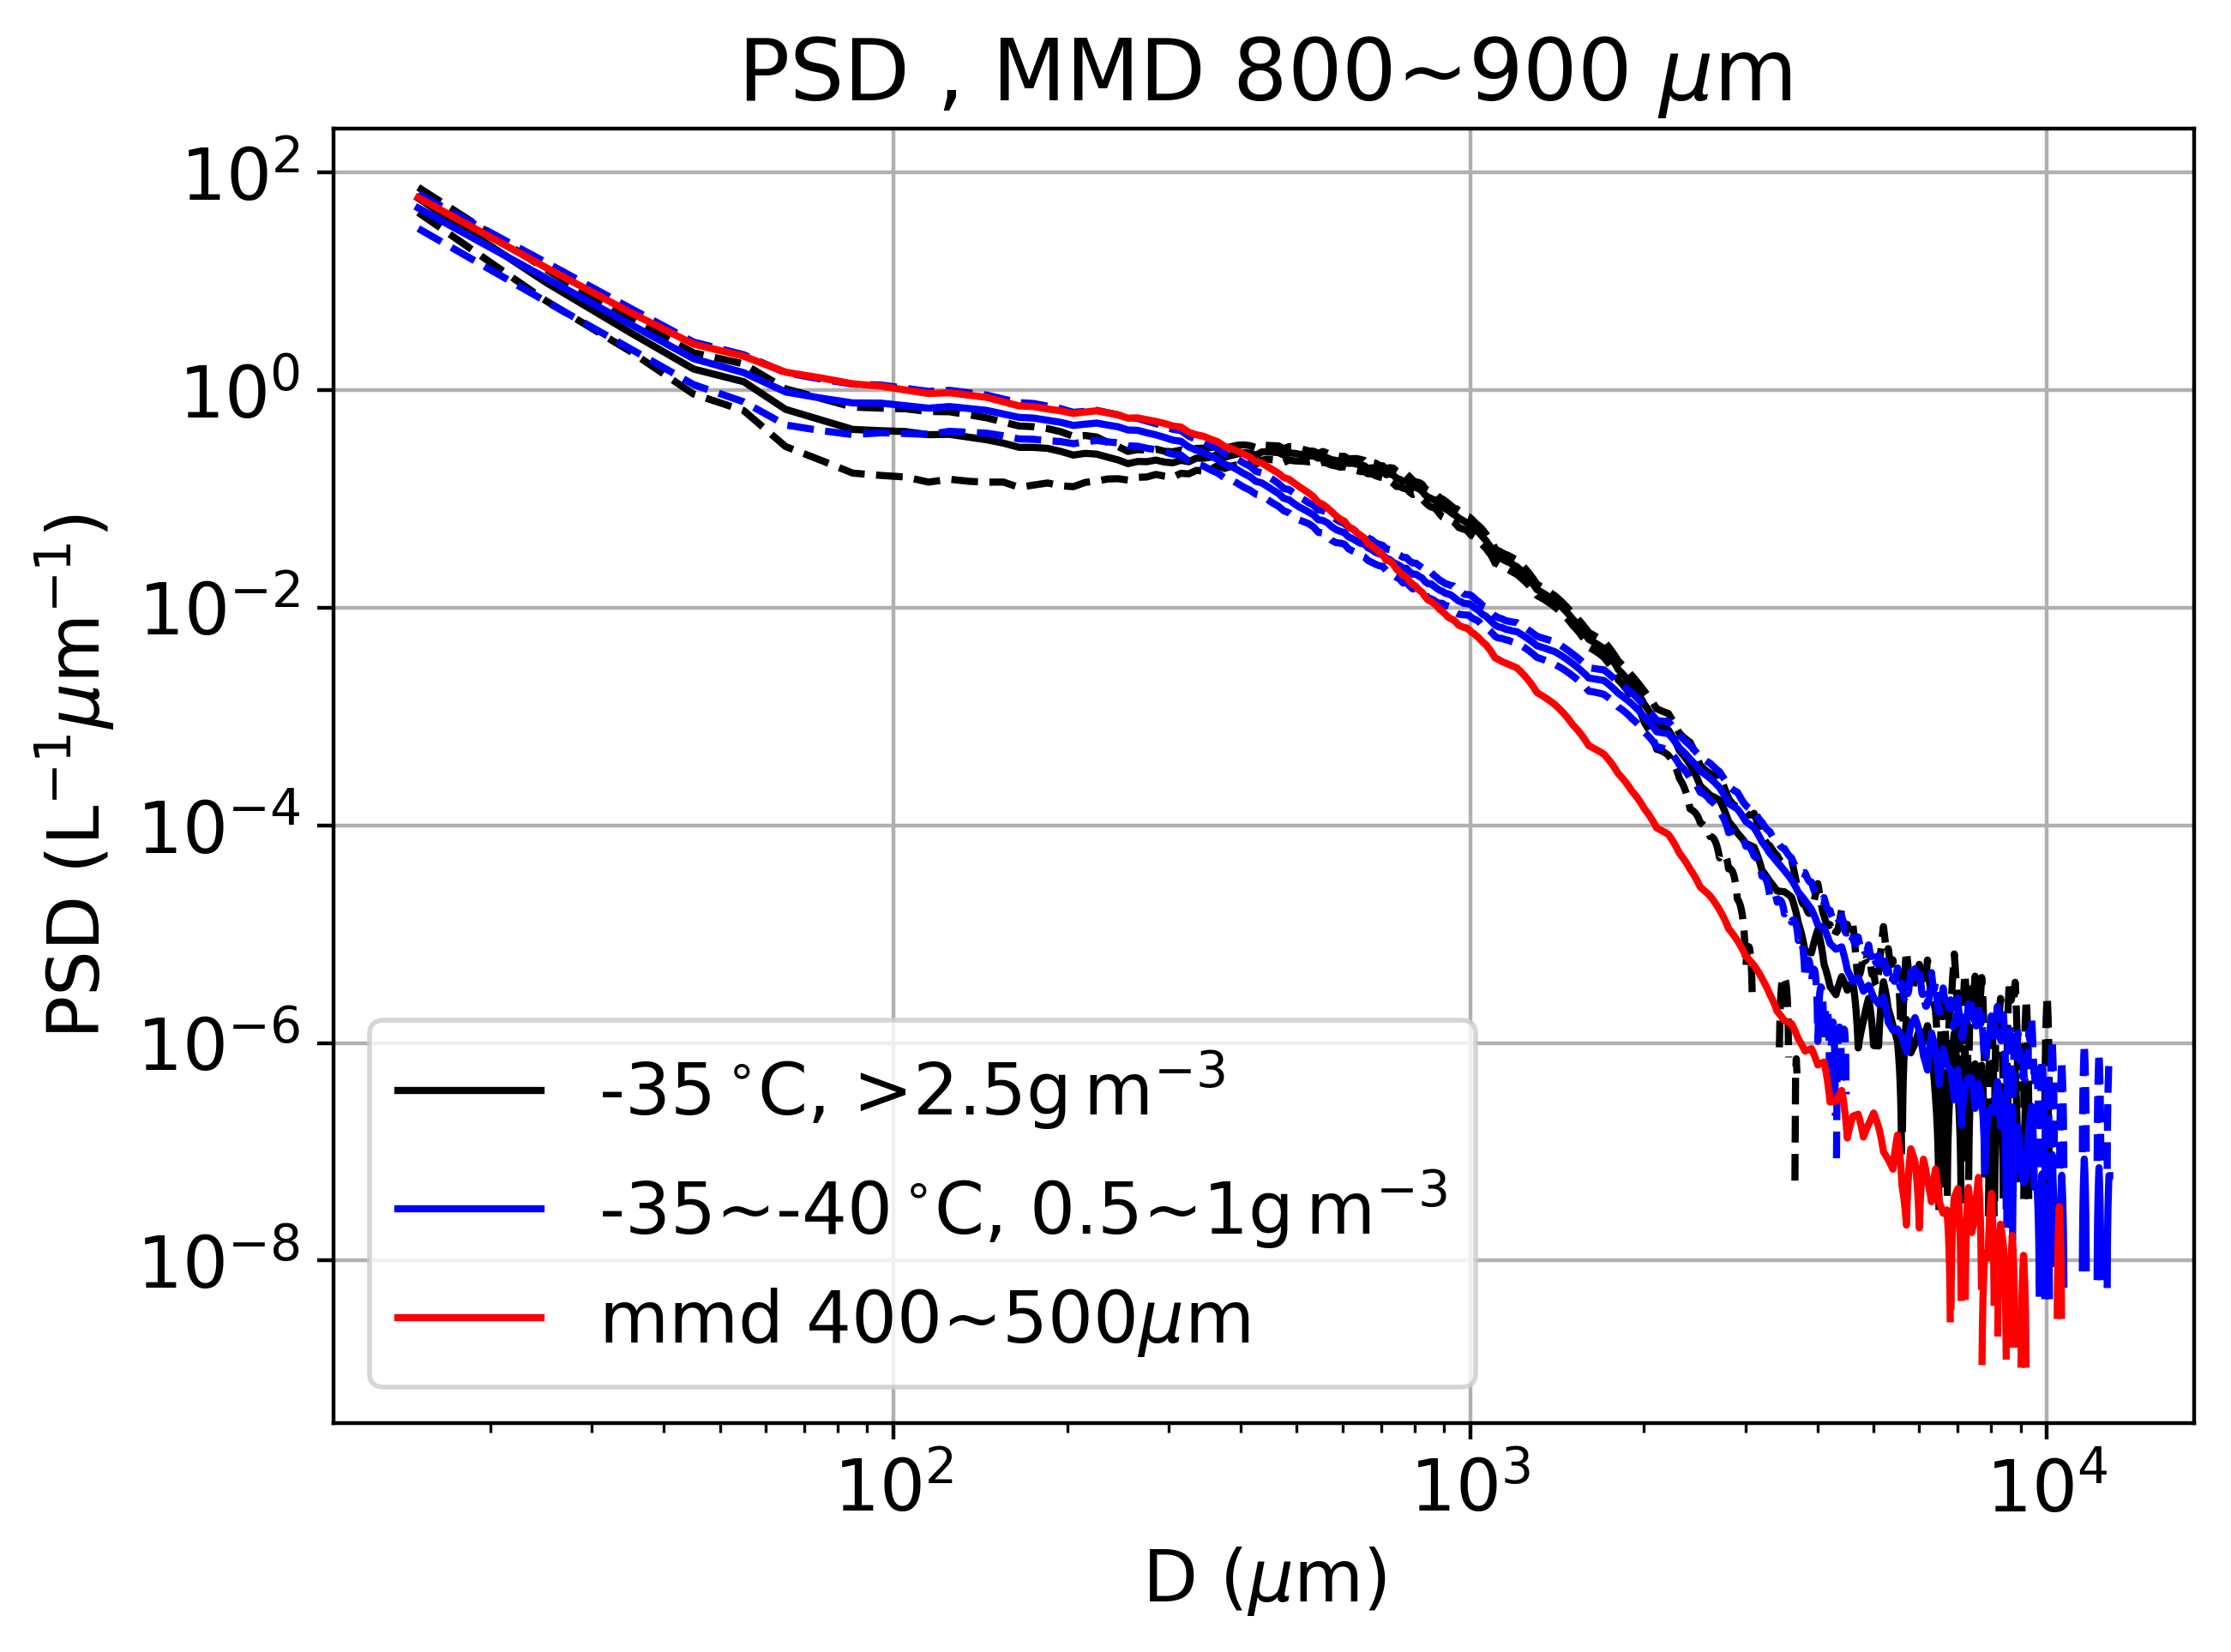

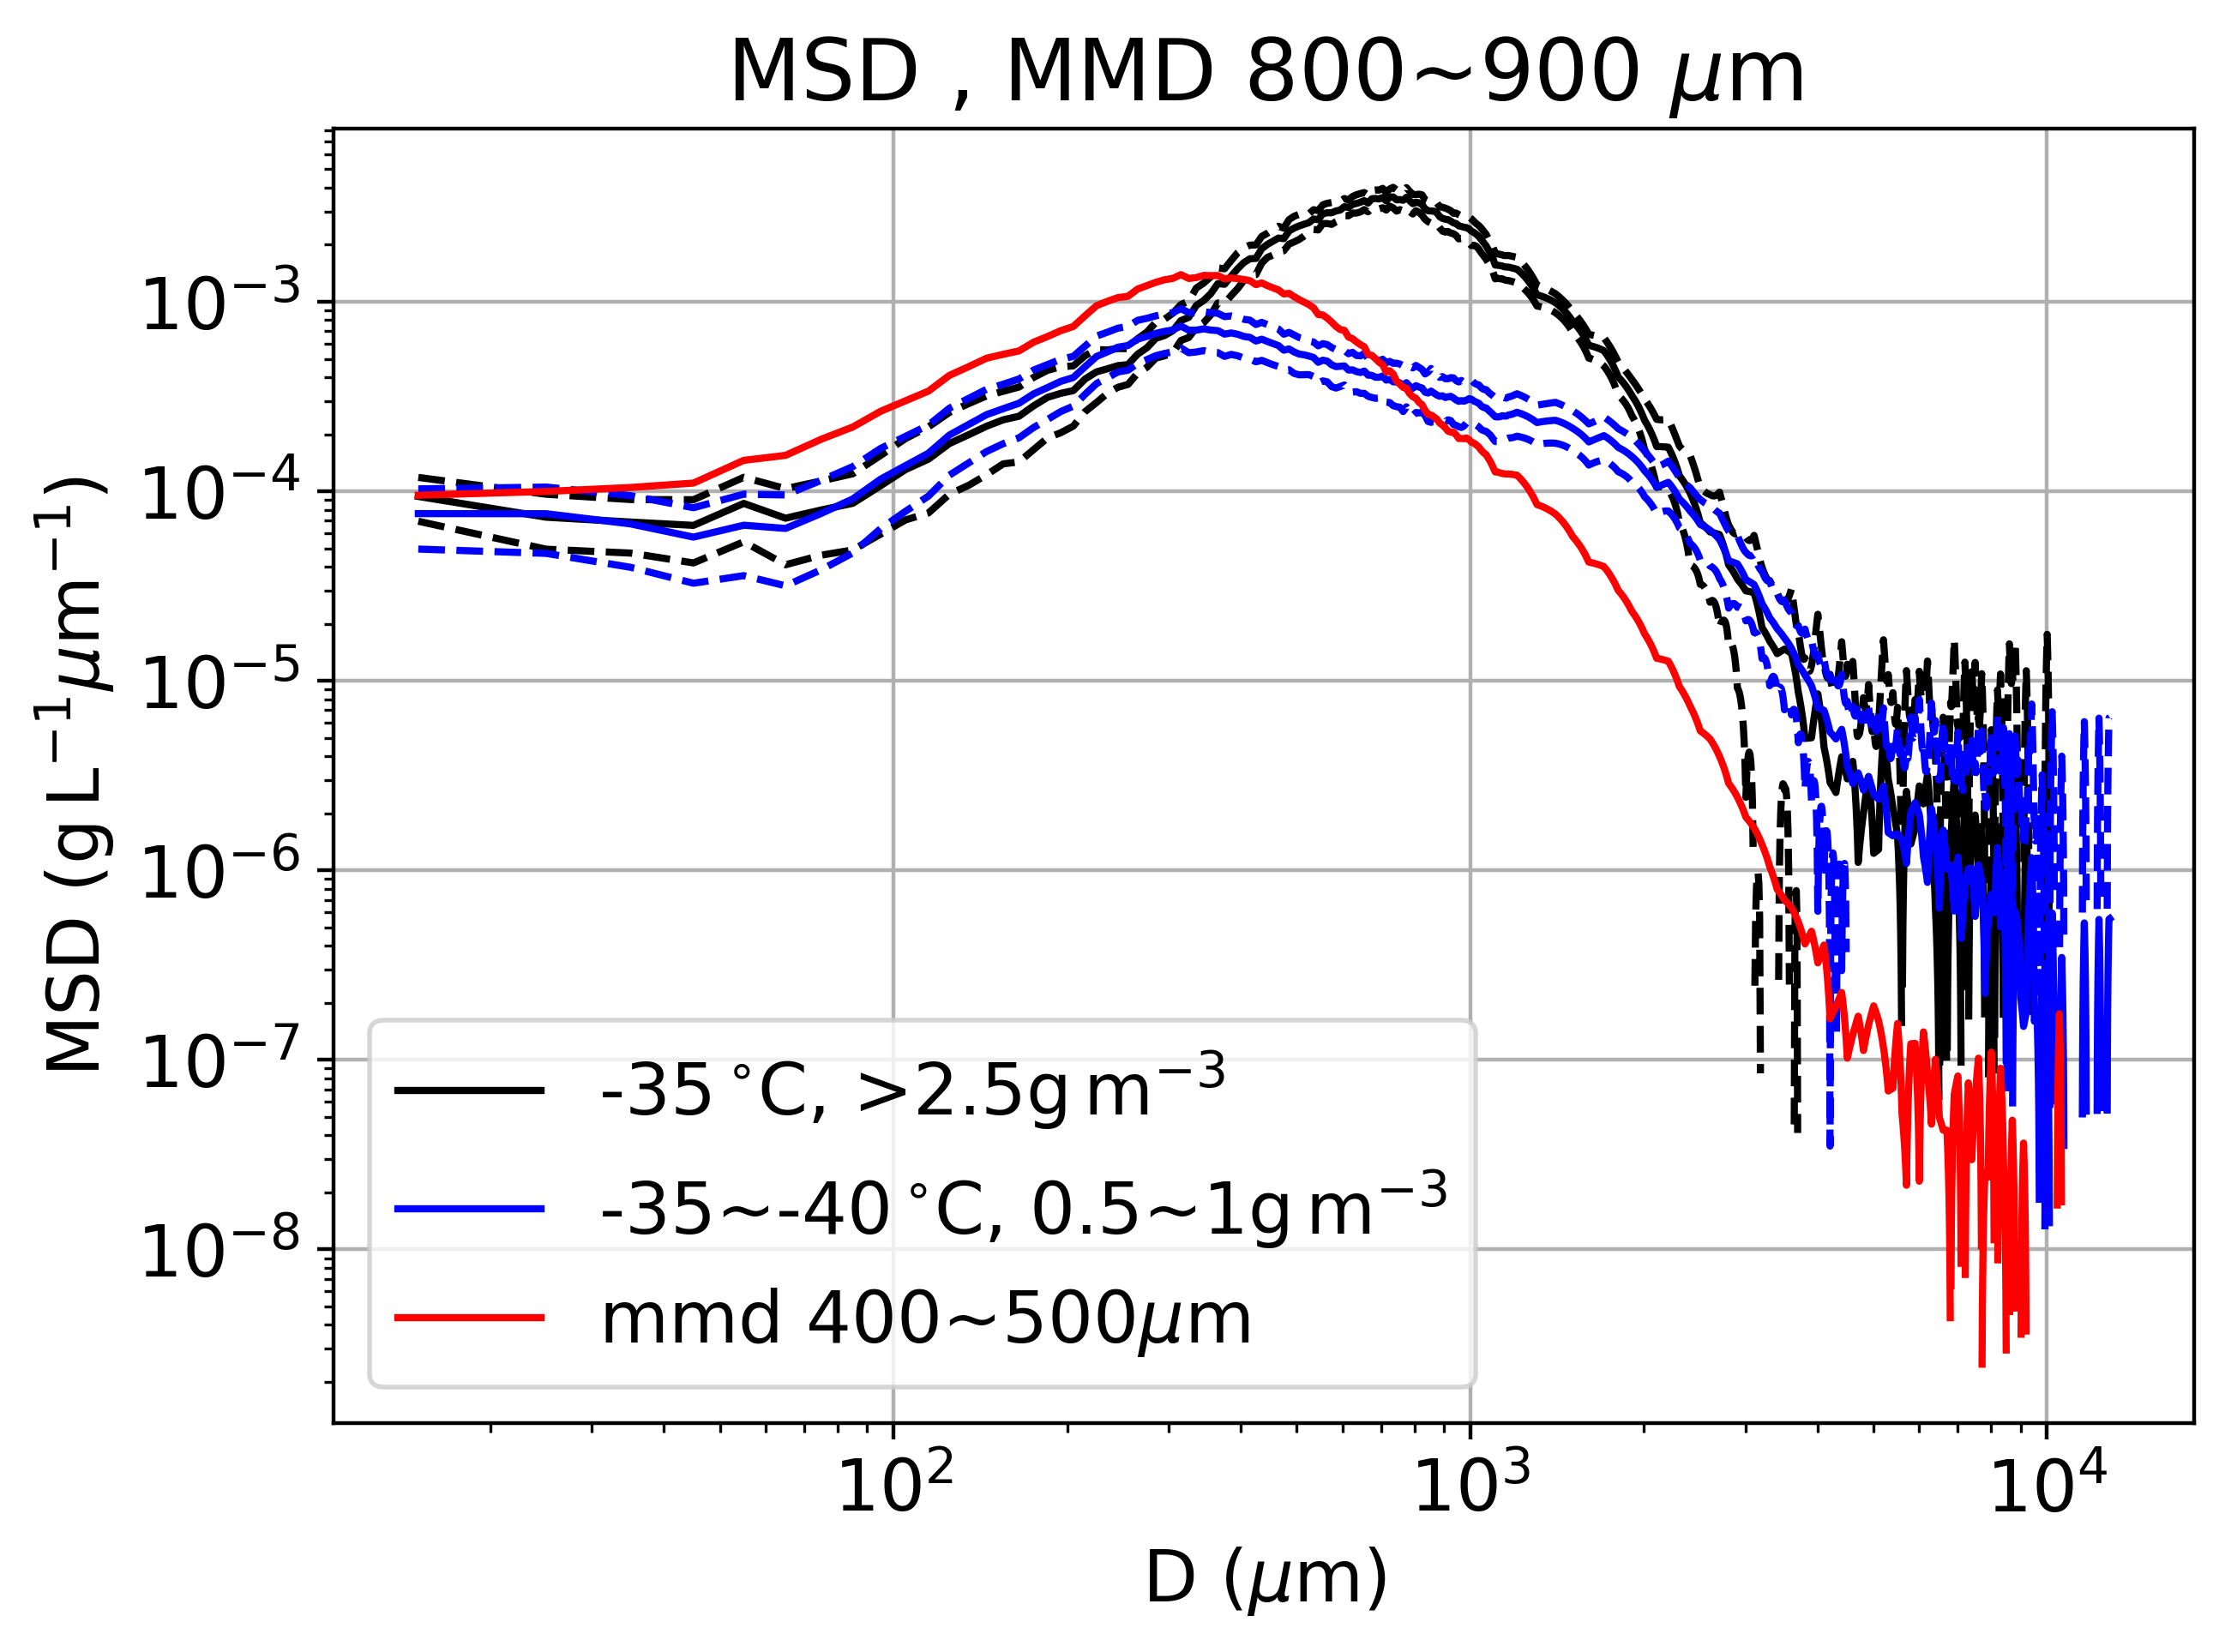

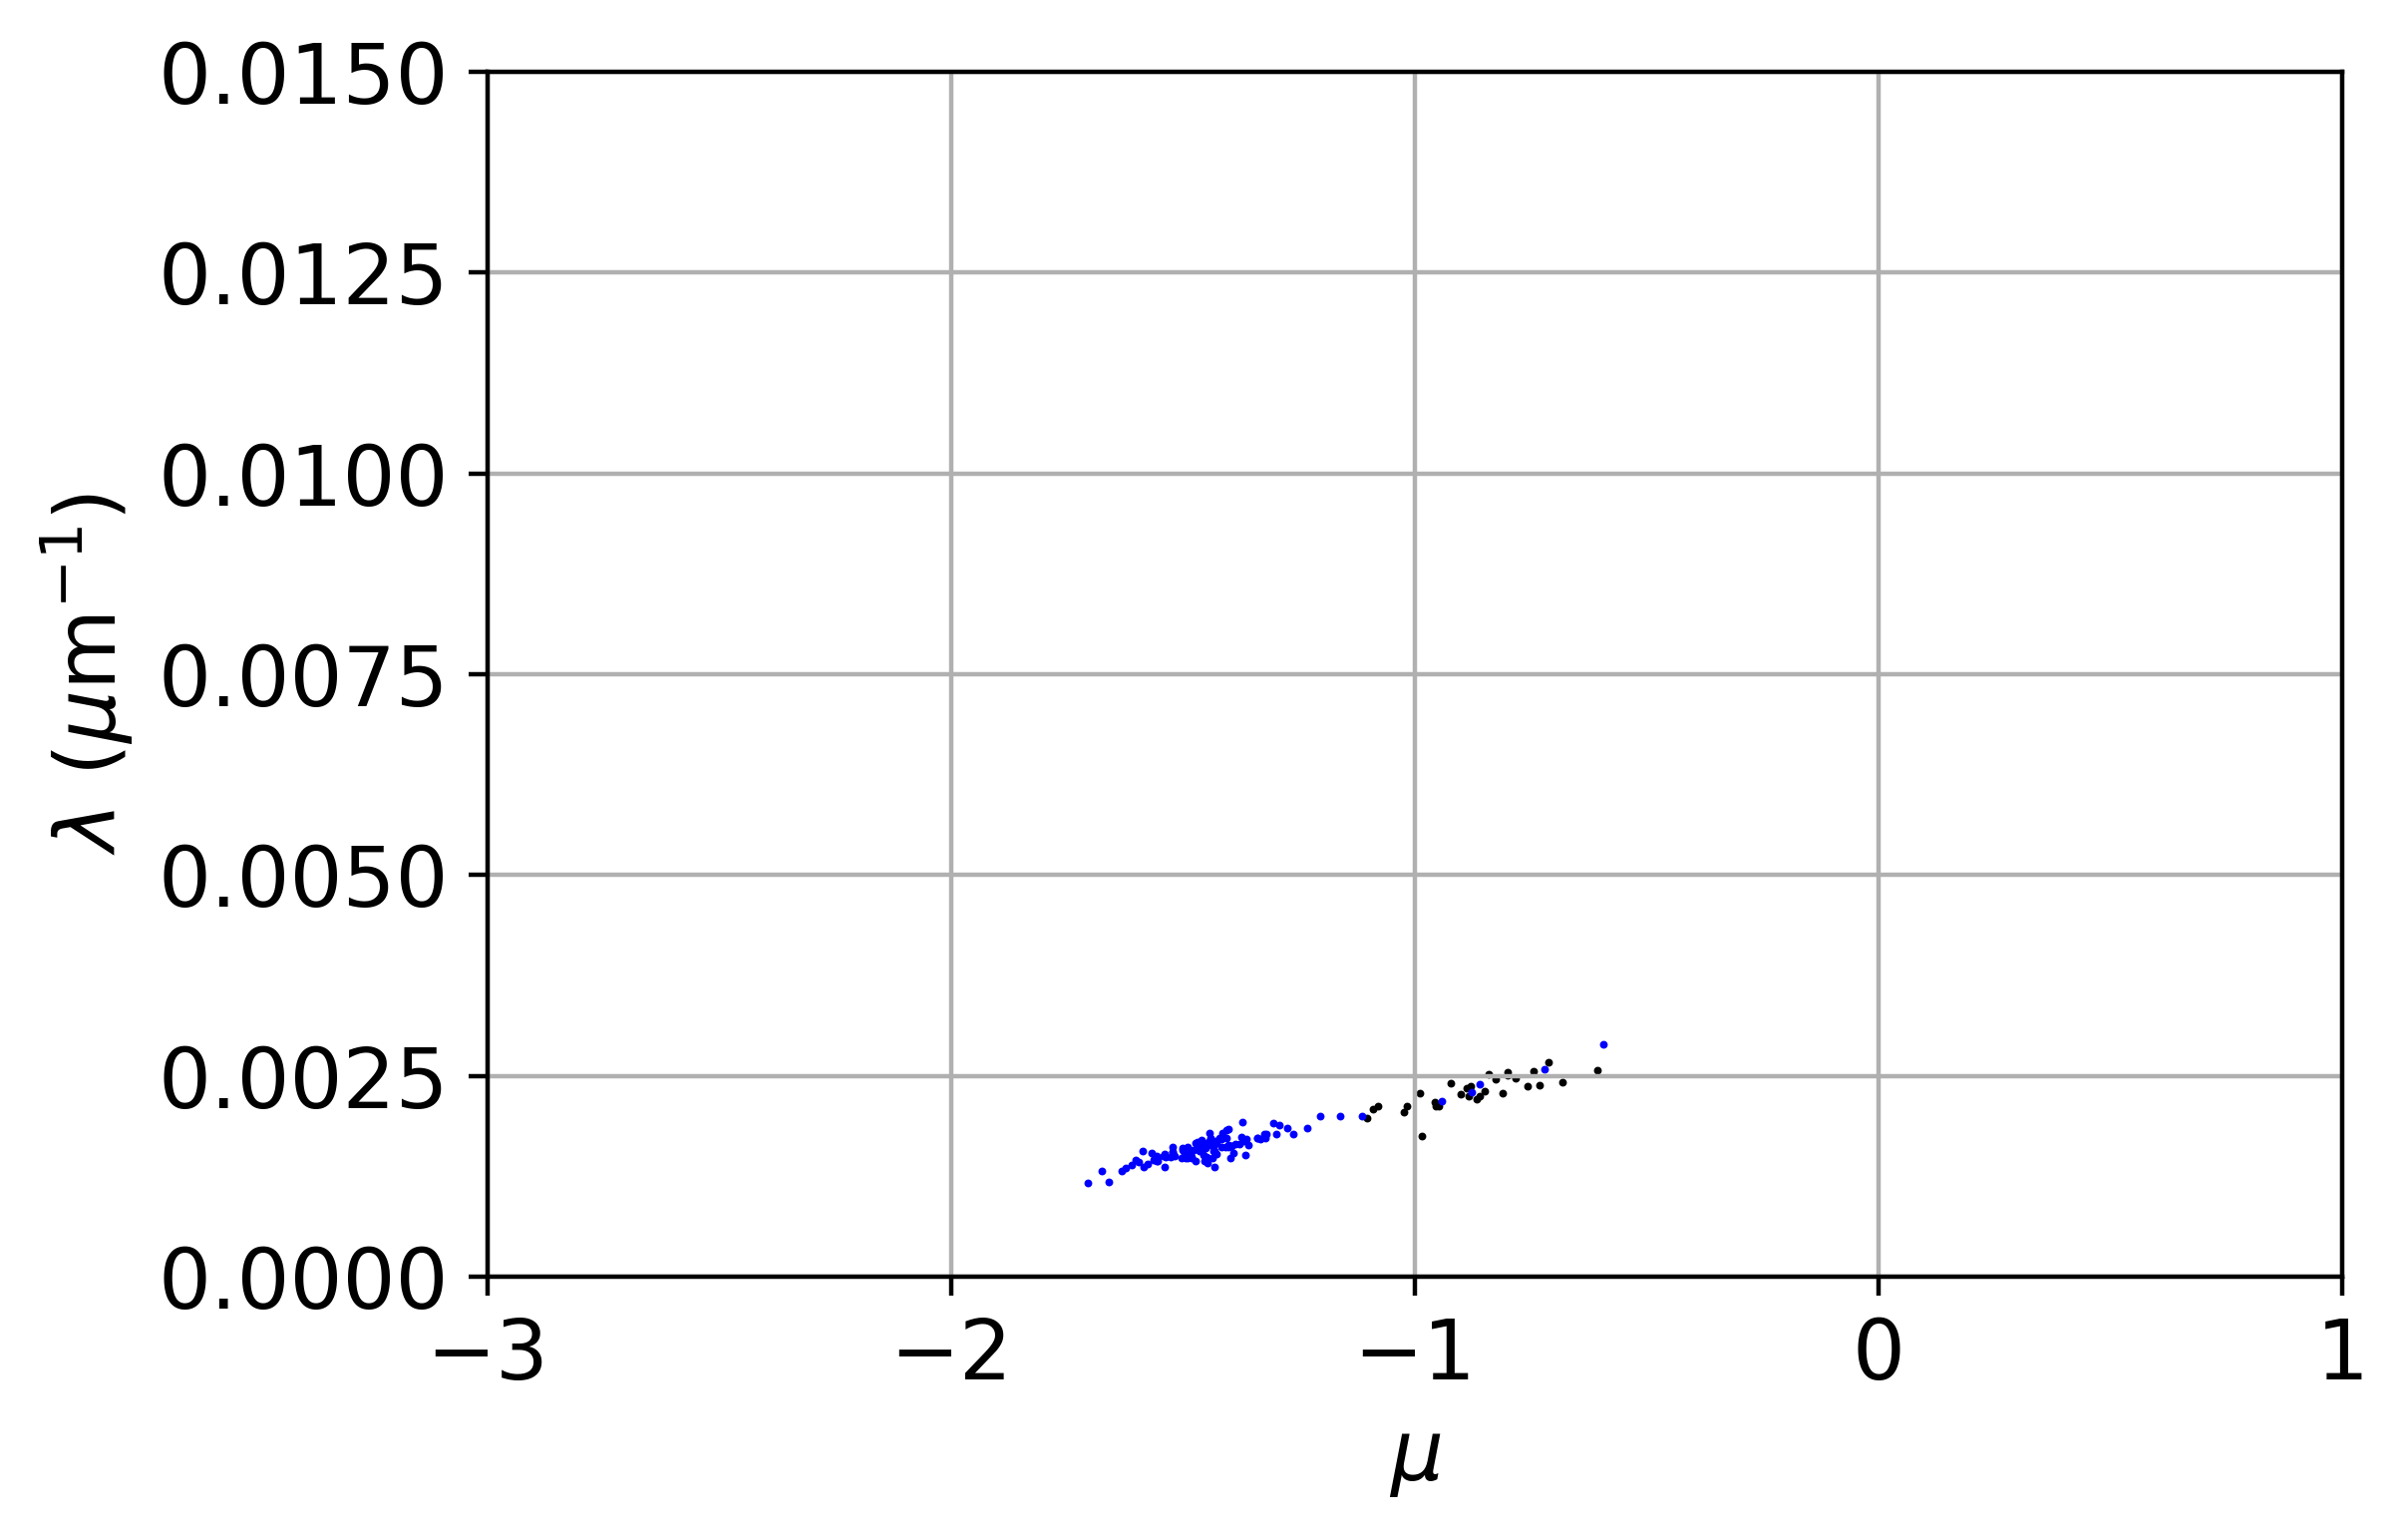

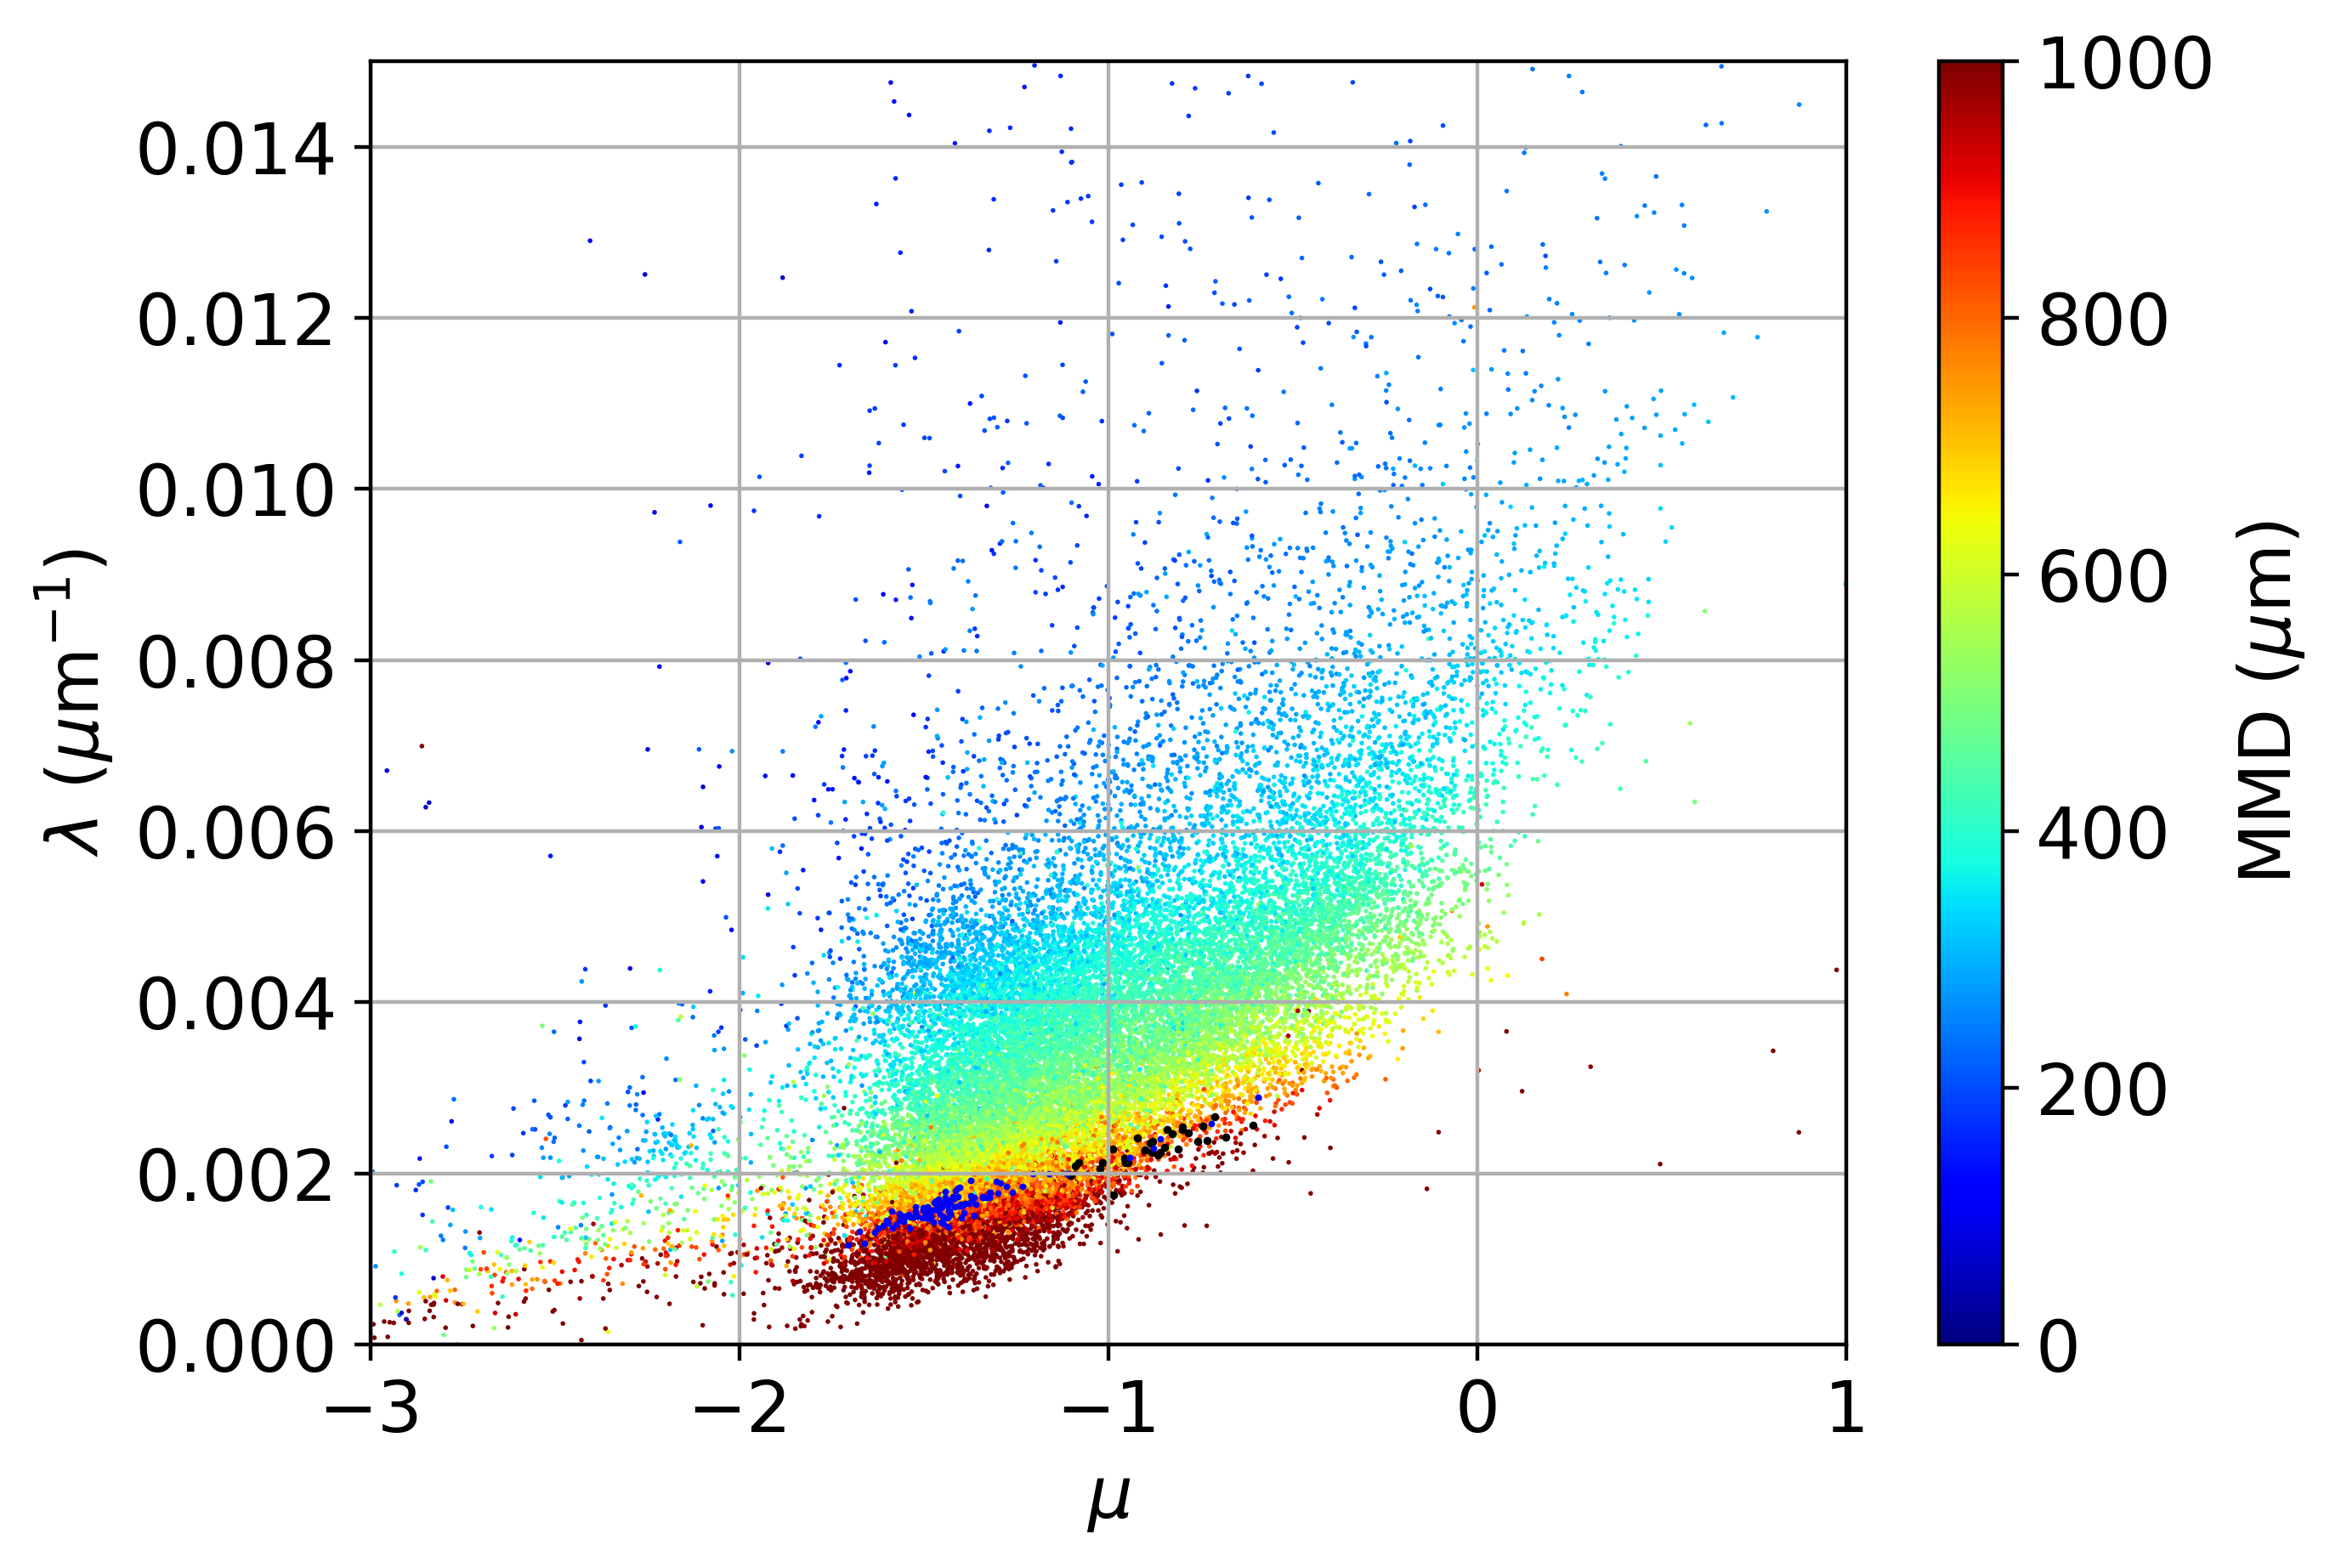

In [10]:
mpl.rc("savefig", dpi=400)
# plt.rcParams['image.cmap'] = 'jet' # Set default colormap to jet
plt.rcParams.update({'font.size': 15}) # Set default fontsize to 20 to accomodate figsize=(11,*)

bin_mid = (bin_div[1:] + bin_div[:-1] )/2.
collection = {'linewidths':0,'antialiaseds':True}

for settings in [[False,'PSD ($\mathrm{L}^{-1}\mu\mathrm{m}^{-1}$)'],[True,'MSD (g$\,\mathrm{L}^{-1}\mu\mathrm{m}^{-1}$)']]:
    plt.figure(figsize=(7,5))
    nonpsd1,psd, _ = subsetdata(tempr=[-37.5,-32.5],iwcr=[2.5,5],mmdr=[800,900],msd=settings[0])
    psdmean = mean(psd,axis=0)
    rc('text', usetex=False)
    plt.loglog(bin_mid,psdmean,'k-',label=r'-35$^\circ\!$C, >2.5g$\,\mathrm{m}^{-3}$')
    psdstd = std(psd,axis=0)
    plt.loglog(bin_mid,psdmean+psdstd,'k--')
    plt.loglog(bin_mid,psdmean-psdstd,'k--')
    plt.grid(b=True)

    nonpsd2,psd, _ = subsetdata(tempr=[-40,-35],iwcr=[.5,1],mmdr=[800,900],msd=settings[0])
    psdmean = mean(psd,axis=0)
    plt.loglog(bin_mid,psdmean,'b-',label='-35~-40$^\circ\!$C, 0.5~1g$\,\mathrm{m}^{-3}$')
    psdstd = std(psd,axis=0)
    plt.loglog(bin_mid,psdmean+psdstd,'b--')
    plt.loglog(bin_mid,psdmean-psdstd,'b--')
    plt.grid(b=True)

    nonpsd,psd,_ = subsetdata(tempr=[-40.,-32.5],iwcr=[.5,1],mmdr=[400,500],msd=settings[0])
    psdmean = mean(psd,axis=0)
    plt.loglog(bin_mid,psdmean,'r-',label='mmd 400~500$\mu$m')
    psdstd = std(psd,axis=0)
    # plt.loglog(bin_mid,psdmean+psdstd,'r--')
    # plt.loglog(bin_mid,psdmean-psdstd,'r--')
    plt.grid(b=True)
    plt.legend(loc='best')
    plt.title(settings[1][:4]+', MMD 800~900 $\mu$m')
    plt.xlabel('D ($\mu$m)')
    plt.ylabel(settings[1])
    plt.show()

scatter(nonpsd1.mu, nonpsd1.ld, c='k', s=2, **collection)
scatter(nonpsd2.mu, nonpsd2.ld, c='b', s=2, **collection)
# cb = plt.colorbar()
# cb.set_label('IWC (g/m3)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ ($\mu\mathrm{m}^{-1}$)')
plt.xlim(-3,1)
plt.ylim(0,.015)
# plt.clim(0,1000)
plt.grid(b=True)

plt.show()

plt.figure(figsize=(7,5))
scatter(dataf.mu, dataf.ld, c=dataf.mmd, s=1, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)

scatter(nonpsd1.mu, nonpsd1.ld, c='k', s=3, **collection)
scatter(nonpsd2.mu, nonpsd2.ld, c='b', s=2, **collection)
# cb = plt.colorbar()
# rc('text',usetex=True)
cb.set_label('MMD ($\mu$m)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ ($\mu\mathrm{m}^{-1}$)')
plt.xlim(-3,1)
plt.ylim(0,.015)
# plt.clim(0,1000)
plt.grid(b=True)

plt.show()

In [11]:
nonpsd1,psd, tmpind1 = subsetdata(tempr=[-37.5,-32.5],iwcr=[2.5,5],mmdr=[800,900],msd=True)
nonpsd1,psd, tmpind2 = subsetdata(tempr=[-40,-35],iwcr=[.5,1],mmdr=[800,900],msd=True)
dataall = rawvar.iloc[tmpind1]
unique(dataall['flightnum'])

array([12, 13])

In [3]:
xl = np.arange(-3,1,.1)
yl = np.arange(0,0.015,0.0005)

xs,ys = np.meshgrid(xl,yl)

f_mygamma = lambda nml, x: 10**nml[0]*x**nml[1]*np.exp(-nml[2]*x)

def f_mmd(bin_div, nml):
    bin_mid = (bin_div[1:] + bin_div[:-1] )/2.
    bin_diff = np.diff(bin_div)
    psd = f_mygamma(nml,bin_mid)
    msd = psd * 0.00294 * (bin_mid/1e4)**1.9
    
    
    cmsd = np.concatenate( (np.array([0]),np.cumsum(msd*bin_diff)) )
    if cmsd[-1]<=0:
        return np.NaN
    cmsd /= cmsd[-1]
    indtmp = np.where(np.diff(cmsd>0.5)==1)[0]
    x1,x2,y1,y2 = bin_div[indtmp], bin_div[indtmp+1], cmsd[indtmp], cmsd[indtmp+1]
    mmd = (x2-x1)/(y2-y1)*(0.5-y1)+x1
    return mmd

mmdarr = np.empty_like(xs)
shp = xs.shape
for i in range(shp[0]):
    for j in range(shp[1]):
        mmdarr[i,j] = f_mmd(bin_div,[1,xs[i,j],ys[i,j]])


/data/keeling/a/szhu28/usr/anaconda2/envs/py3k/lib/python3.5/site-packages/pandas/core/internals.py:252: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self.values[slicer]
/data/keeling/a/szhu28/usr/anaconda2/envs/py3k/lib/python3.5/site-packages/pandas/tseries/base.py:276: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getitem(key)
/data/keeling/a/szhu28/usr/anaconda2/envs/py3k/lib/python3.5/site-packages/pandas/core/series.py:712: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._values[indexer]


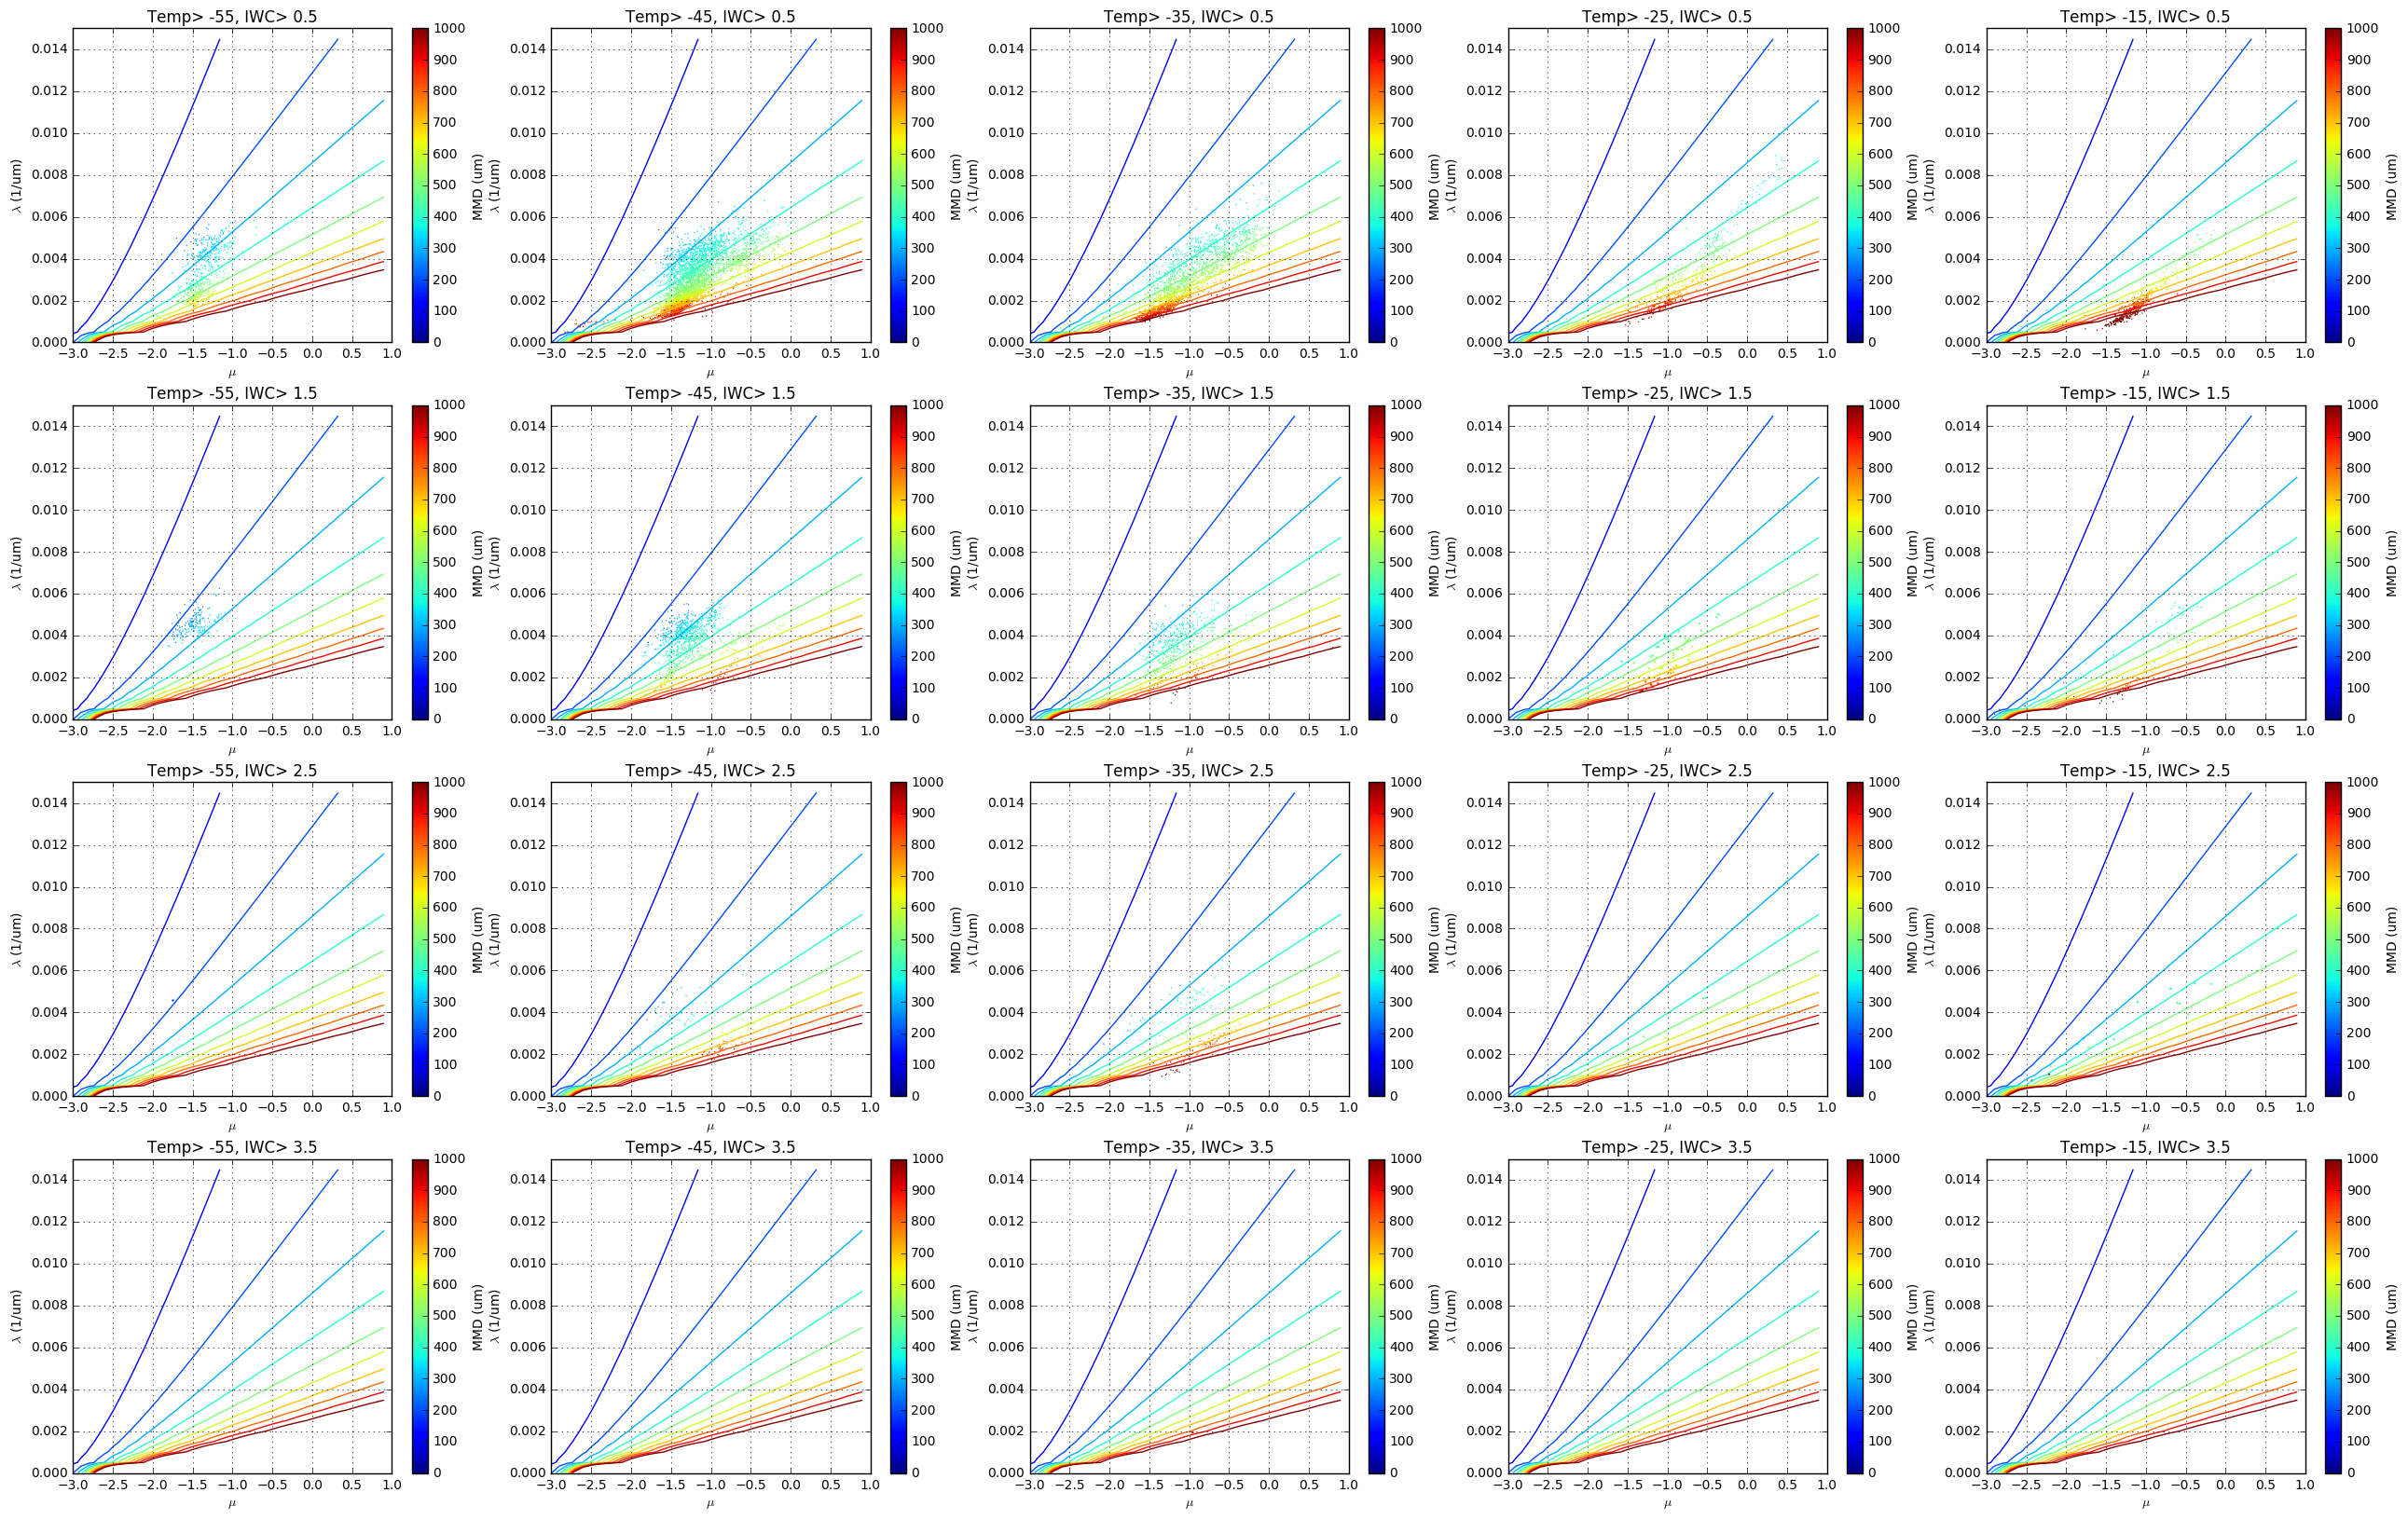

In [4]:
# warnings.simplefilter("error")
collection = {'linewidths':0,'antialiaseds':True}
bin_mid = (bin_div[1:] + bin_div[:-1] )/2.
count=1
tempbins = np.arange(-55,0,10)
iwcbins = np.arange(.5,5,1)
plt.figure(figsize=[32,20],dpi=1000)
for iiwc in range(len(iwcbins)-1):
    iwcr = iwcbins[[iiwc,iiwc+1]]
    for itemp in range(len(tempbins)-1):
        tempr = tempbins[[itemp,itemp+1]]
        plt.subplot(len(iwcbins)-1,len(tempbins)-1,count)
        count+=1
        nonpsd,psd,_ = subsetdata(tempr=tempr,iwcr=iwcr)#,mmdr=[800,900])
        if len(nonpsd) <100:
            dotsize = 3
        else:
            dotsize = 1
        tmp = scatter(nonpsd.mu, nonpsd.ld, c=nonpsd.mmd, s=dotsize, **collection)
        cb = plt.colorbar()
        cb.set_label('MMD (um)')
        plt.xlabel('$\mu$')
        plt.ylabel(r'$\lambda$ (1/um)')
        plt.xlim(-3,1)
        plt.ylim(0,.015)
        plt.clim(0,1000)
        plt.grid(b=True)
        plt.title('Temp> '+str(tempr[0])+', IWC> '+str(iwcr[0]))
        plt.contour(xs,ys,mmdarr,norm=tmp.norm,levels=np.arange(0,1000.1,100))
# plt.show()
# savefig('tmp.pdf')

In [6]:
subsetdata(tempr=tempr,iwcr=iwcr)

(Empty DataFrame
 Columns: [GMT, SIAltm, SINShead, SRHWVSS, SSAT, STAS, STAT, Slat, Slong, Spress, Stimech, Swdir, Swspd, Szaccg, TWC_robust, Timeinsecond, XKBZR5s, air_pressure, air_temperature, air_temperature.1, air_temperature.2, altitude, altitude.1, angle_of_attack, angle_of_sideslip, dew_point_temperature, eastward_wind, event_marker, flightnum, humidity_mixing_ratio, humidity_mixing_ratio.1, humidity_mixing_ratio.2, latitude, longitude, mic_msofreqice_rs_sync_1, northward_wind, platform_acceleration, platform_course, platform_course.1, platform_orientation, platform_pitch_angle, platform_roll_angle, platform_speed_wrt_air, platform_speed_wrt_ground, platform_speed_wrt_ground.1, relative_humidity, upward_air_velocity, upward_platform_speed_wrt_ground, wind_from_direction, wind_speed, indpsdforward, temp, n0, mu, ld, mmd, iwc]
 Index: []
 
 [0 rows x 57 columns], Empty DataFrame
 Columns: [15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 

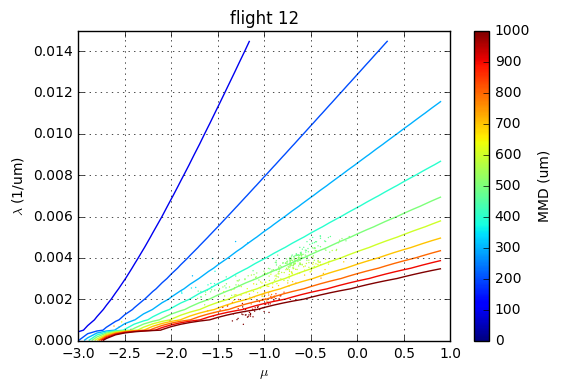

In [17]:
# warnings.simplefilter("error")
collection = {'linewidths':0,'antialiaseds':True}
bin_mid = (bin_div[1:] + bin_div[:-1] )/2.

nonpsd,psd,_ = subsetdata(iwcr=[1,inf],flightnum=12)

if len(nonpsd) <100:
    dotsize = 3
else:
    dotsize = 1
tmp = scatter(nonpsd.mu, nonpsd.ld, c=nonpsd.mmd, s=dotsize, **collection)
cb = plt.colorbar()
cb.set_label('MMD (um)')
plt.xlabel('$\mu$')
plt.ylabel(r'$\lambda$ (1/um)')
plt.xlim(-3,1)
plt.ylim(0,.015)
plt.clim(0,1000)
plt.grid(b=True)
plt.title('flight 12')
plt.contour(xs,ys,mmdarr,norm=tmp.norm,levels=np.arange(0,1000.1,100))
# plt.show()
# savefig('tmp.pdf')